In [1]:
# A piece of code which models hydrogen and ammonia storage separately
# Import all the necessary packages
from dataclasses import dataclass
from typing import NamedTuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
#import some data
df_epr1MW= pd.read_csv("ninja_pv_eynsham_PR_1MW.csv", index_col=0,parse_dates=True,dayfirst=True, delimiter=",")

#import value used to turn area into power capacity
power_intensity_epr = 90 #W/m2

In [3]:
#use function to lump into useful class

#INPUTS: 1MW hourly dataframe, capacity (W), power intensity W/m^2)
#OUTPUTS: dataframes with specified capacity, annual output, area of that capacity
def Produce_PV_Farm_Structure(DF_HOUR_1MW,CAPACITY,POWER_INTENSITY):
    
    
    capacity_ratio = int(CAPACITY/1e6) #capacity in MW

    #scale up 1MW data figure
    DF_HOUR=DF_HOUR_1MW.multiply(capacity_ratio)
    
    DF_DAY = DF_HOUR.resample("D").sum()
    DF_YEAR = DF_HOUR.resample("Y").sum()
    ANNUAL_OUTPUT = DF_YEAR["electricity (kWh)"].item()
    AREA = CAPACITY/(POWER_INTENSITY)


    @dataclass
    class User(NamedTuple):
        name: str


    # determine the different aspects of the PV_Farm, and the nature of each aspect (float, string etc)
    class PV_Farm(NamedTuple):
        #capacity in W
        Capacity: float
        #dataframe of hourly output
        df_hour: pd.DataFrame
        #dataframe of daily output
        df_day: pd.DataFrame
        #annual production of energy (kWh)
        Annual_Output: float
        #area in metres squared
        Area: float

    PV_Farm_Out = PV_Farm(Capacity=CAPACITY,df_hour=DF_HOUR,df_day=DF_DAY,Annual_Output=ANNUAL_OUTPUT,Area=AREA)

    return PV_Farm_Out

#as example, make class for a 1MW plant
capacity_epr1MW = 1e6 #W
PV_Epr1MW = Produce_PV_Farm_Structure(df_epr1MW,capacity_epr1MW,power_intensity_epr)


10000000.0
27397.260273972603


2221.908

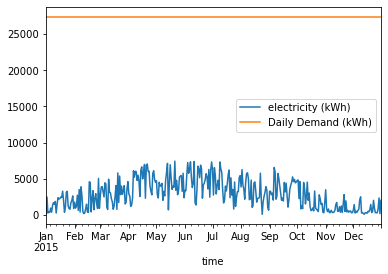

In [4]:
#annual demand in Wh; this is the electrical energy which is required for the trains over the course of a year
Annual_Demand_end = 10e6 # =10GWh a year

#daily demand in Wh; this is the electrical energy needed by the trains every day
daily_demand_end = Annual_Demand_end/365

print(Annual_Demand_end)
print(daily_demand_end)

#turn into a vector of the same length as the daily df
NDays = len(PV_Epr1MW.df_day.index)
Daily_Demand_End_Vector = np.zeros(NDays)

for i in range(0,NDays):
    Daily_Demand_End_Vector[i] = daily_demand_end
    i+=1

Daily_Demand_End_List = list(Daily_Demand_End_Vector)

#lump into one dataframe
PV_Epr1MW_supp_demand = PV_Epr1MW.df_day
PV_Epr1MW_supp_demand['Daily Demand (kWh)']=Daily_Demand_End_List
PV_Epr1MW_supp_demand.plot()
PV_Epr1MW_supp_demand['electricity (kWh)'][50]

We are now going to model storage of Hydrogen and Ammonia separately, using an initial power capacity of 23MW for our solar farm. The amount of solar electricity going to hydrogen storage will at most be enough to supply the following day's daily demand (assumed constant each day). If there is any surplus, it will go to ammonia storage.

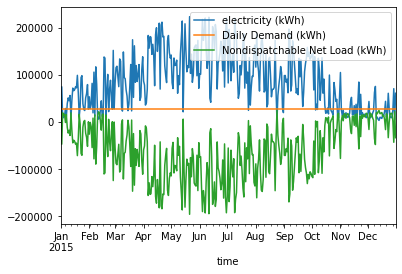

In [498]:
capacity_a = 30e6#starting point for capacity of solar farm

#turn into a class
PV_a = Produce_PV_Farm_Structure(df_epr1MW,capacity_a,power_intensity_epr)
PV_a_supp_demand = PV_a.df_day
PV_a_supp_demand['Daily Demand (kWh)']=Daily_Demand_End_List
PV_a_supp_demand['Nondispatchable Net Load (kWh)']=PV_a_supp_demand['Daily Demand (kWh)'] - PV_a_supp_demand['electricity (kWh)']
PV_a_supp_demand.plot()



#add in storage of Hydrogen
eff_h2 = (0.56) #efficiency of electricity in -> energy into storage (assume same as energy in storage --> electricity out)

p_cap_h2 = max(abs(PV_a_supp_demand['Nondispatchable Net Load (kWh)']))/eff_h2 #power capacity of H2 in kWh/day
e_cap_h2 = daily_demand_end/eff_h2 #energy capacity should be a day's storage

#shorthand for the nondispatchable net load, put in list for ease
nd_nl = PV_a_supp_demand['Nondispatchable Net Load (kWh)'].values.tolist()

outputi_h2 = np.zeros((NDays,1)) # storage energy flow; assume all is in ammonia for the time being
soc_h2 = np.zeros((NDays,1))

#start with one day's storage
soc_h2[0] = PV_a_supp_demand['Daily Demand (kWh)'].resample('D').sum()[0]*1


#use battery model for hydrogen
for j in range(NDays):
    
    #charge in battery on 1st jan
    if j==0:
        socval = soc_h2[0]
    else:
        socval = soc_h2[j-1]
        
    #determine battery operation depending on nondispatchable net load
    if nd_nl[j] > 0:
        #power flow into battery is either the capacity, nondispatchable net load, or existing state of charge (if it is fully charged)
        outputi_h2[j]=min((p_cap_h2),nd_nl[j],eff_h2*socval) #amount of power flowing out of storage; * by eff due to losses
        soc_h2[j] = socval - (1/eff_h2)*outputi_h2[j]
        
    elif nd_nl[j] < 0:
        outputi_h2[j]=max(-p_cap_h2,nd_nl[j],-(1/eff_h2)*(e_cap_h2-socval)) #amount of power flowing into storage
        soc_h2[j] = socval - eff_h2*outputi_h2[j]
        
    elif nd_nl[j] == 0:
        soc_h2[j] = socval
        
#calculate the net load of the final system
net_load_h2 = nd_nl - outputi_h2
net_load_h2 = net_load_h2[0]
net_load_h2 = net_load_h2.tolist()

#append net load with hydrogen storage to dataframe and plot...
PV_a_supp_demand['Net Load with H2 only (kWh)'] = net_load_h2
PV_a_supp_demand['H2 State of Charge (kWh)'] = soc_h2
PV_a_supp_demand['H2 Energy Output (kWh)'] = outputi_h2
PV_a_supp_demand['Demand met by H2 (kWh)'] = PV_a_supp_demand['Nondispatchable Net Load (kWh)'] - PV_a_supp_demand['Net Load with H2 only (kWh)']



#add in ammonia storage
eff_nh3 = (0.32) #efficiency of electricity in -> energy into storage (assume same as energy in storage --> electricity out)

p_cap_nh3 = max(abs(PV_a_supp_demand['electricity (kWh)'])) #power capacity of H2 in kWh/day
e_cap_nh3 = PV_a_supp_demand['Daily Demand (kWh)'].resample('M').sum()[0]*12 #kWh, year's supply


outputi_nh3 = np.zeros((NDays,1)) # storage energy flow; assume all is in ammonia for the time being
soc_nh3 = np.zeros((NDays,1))

#start with two months storage
soc_nh3[0] = PV_a_supp_demand['Daily Demand (kWh)'].resample('M').sum()[0]*2


#use battery model for hydrogen
for j in range(NDays):
    
    #charge in battery on 1st jan
    if j==0:
        socval2 = soc_nh3[0]
    else:
        socval2 = soc_nh3[j-1]
        
    #determine battery operation depending on nondispatchable net load
    if net_load_h2[j] > 0:
        #power flow into battery is either the capacity, nondispatchable net load, or existing state of charge (if it is fully charged)
        outputi_nh3[j]=min((p_cap_nh3),net_load_h2[j],eff_nh3*socval2) #amount of power flowing out of storage; * by eff due to losses
        soc_nh3[j] = socval2 - (1/eff_nh3)*outputi_nh3[j]
        
    elif net_load_h2[j] < 0:
        outputi_nh3[j]=max(-p_cap_nh3,net_load_h2[j],-(1/eff_nh3)*(e_cap_nh3-socval2)) #amount of power flowing into storage
        soc_nh3[j] = socval2 - eff_nh3*outputi_nh3[j]
        
    elif net_load_h2[j] == 0:
        soc_nh3[j] = socval2
        
#calculate the net load of the final system
net_load_nh3 = net_load_h2 - outputi_nh3
net_load_nh3 = net_load_nh3[0]
net_load_nh3 = net_load_nh3.tolist()

#append net load with hydrogen storage to dataframe and plot...
PV_a_supp_demand['Net Load with NH3 (kWh)'] = net_load_nh3
PV_a_supp_demand['NH3 State of Charge (kWh)'] = soc_nh3
PV_a_supp_demand['NH3 Energy Output (kWh)'] = outputi_nh3
PV_a_supp_demand['Demand met by NH3 (kWh)'] = PV_a_supp_demand['Nondispatchable Net Load (kWh)'] - PV_a_supp_demand['Net Load with NH3 (kWh)']


We can now put in Ammonia storage; considering that the net load with Hydrogen is now the 'nondispatchable net load' when considering ammonia storage.

In [499]:
x=0
demand=15e6  #assume to be 15GWh
daily_H2_demand=demand/365
for i in range(365):
   
    if PV_a_supp_demand['electricity (kWh)'][i]/2<daily_H2_demand:
        x=x+1
        
x

188

This part aims to determine H2 size if no NH3 is used

oh no


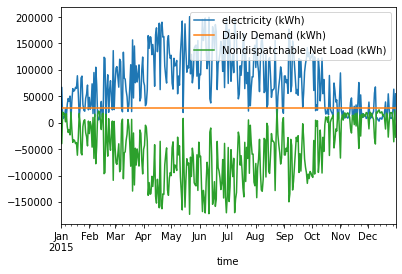

In [510]:
capacity_a = 27e6#starting point for capacity of solar farm

#turn into a class
PV_a = Produce_PV_Farm_Structure(df_epr1MW,capacity_a,power_intensity_epr)
PV_a_supp_demand = PV_a.df_day
PV_a_supp_demand['Daily Demand (kWh)']=Daily_Demand_End_List
PV_a_supp_demand['Nondispatchable Net Load (kWh)']=PV_a_supp_demand['Daily Demand (kWh)'] - PV_a_supp_demand['electricity (kWh)']
PV_a_supp_demand.plot()
h_stored=np.zeros((366,1))
h_stored[0]=60*daily_H2_demand

defficit=[]

for i in range(365):
    daily_h=0 #kwh
    daily_less=0
    x=0
    if PV_a_supp_demand['electricity (kWh)'][i]*0.56>daily_H2_demand:
        daily_excess=PV_a_supp_demand['electricity (kWh)'][i]-daily_H2_demand/0.56
        h_stored[i+1]= h_stored[i]+daily_excess*0.56*0.85

    if PV_a_supp_demand['electricity (kWh)'][i]*0.56<=daily_H2_demand:
        daily_less=daily_H2_demand-PV_a_supp_demand['electricity (kWh)'][i]*0.56
        h_stored[i+1]= h_stored[i]-daily_less
    h_stored[i+1]=h_stored[i+1]*0.97
    if  h_stored[i]<=0:
        print('oh no')
        break

 


oh no


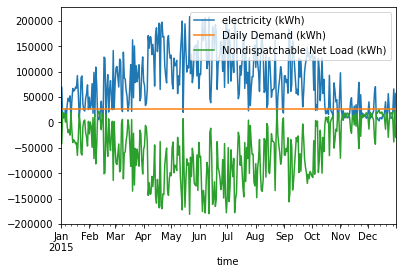

In [511]:
capacity_a = 28e6#starting point for capacity of solar farm

#turn into a class
PV_a = Produce_PV_Farm_Structure(df_epr1MW,capacity_a,power_intensity_epr)
PV_a_supp_demand = PV_a.df_day
PV_a_supp_demand['Daily Demand (kWh)']=Daily_Demand_End_List
PV_a_supp_demand['Nondispatchable Net Load (kWh)']=PV_a_supp_demand['Daily Demand (kWh)'] - PV_a_supp_demand['electricity (kWh)']
PV_a_supp_demand.plot()
h_stored2=np.zeros((366,1))
h_stored2[0]=60*daily_H2_demand

defficit=[]

for i in range(365):
    daily_h=0 #kwh
    daily_less=0
    x=0
    if PV_a_supp_demand['electricity (kWh)'][i]*0.56>daily_H2_demand:
        daily_excess=PV_a_supp_demand['electricity (kWh)'][i]-daily_H2_demand/0.56
        h_stored2[i+1]= h_stored2[i]+daily_excess*0.56*0.85

    if PV_a_supp_demand['electricity (kWh)'][i]*0.56<=daily_H2_demand:
        daily_less=daily_H2_demand-PV_a_supp_demand['electricity (kWh)'][i]*0.56
        h_stored2[i+1]= h_stored2[i]-daily_less
    h_stored2[i+1]=h_stored2[i+1]*0.97
    if  h_stored2[i]<=0:
        print('oh no')
        break

oh no


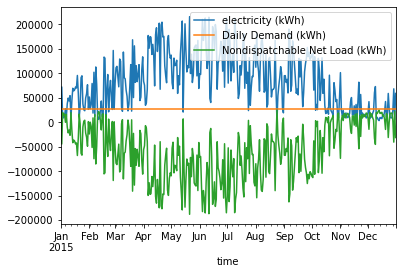

In [512]:
capacity_a = 29e6#starting point for capacity of solar farm

#turn into a class
PV_a = Produce_PV_Farm_Structure(df_epr1MW,capacity_a,power_intensity_epr)
PV_a_supp_demand = PV_a.df_day
PV_a_supp_demand['Daily Demand (kWh)']=Daily_Demand_End_List
PV_a_supp_demand['Nondispatchable Net Load (kWh)']=PV_a_supp_demand['Daily Demand (kWh)'] - PV_a_supp_demand['electricity (kWh)']
PV_a_supp_demand.plot()
h_stored3=np.zeros((366,1))
h_stored3[0]=60*daily_H2_demand

defficit=[]

for i in range(365):
    daily_h=0 #kwh
    daily_less=0
    x=0
    if PV_a_supp_demand['electricity (kWh)'][i]*0.56>daily_H2_demand:
        daily_excess=PV_a_supp_demand['electricity (kWh)'][i]-daily_H2_demand/0.56
        h_stored3[i+1]= h_stored3[i]+daily_excess*0.56*0.85

    if PV_a_supp_demand['electricity (kWh)'][i]*0.56<=daily_H2_demand:
        daily_less=daily_H2_demand-PV_a_supp_demand['electricity (kWh)'][i]*0.56
        h_stored3[i+1]= h_stored3[i]-daily_less
    h_stored3[i+1]=h_stored3[i+1]*0.97
    if  h_stored3[i]<=0:
        print('oh no')
        break

oh no


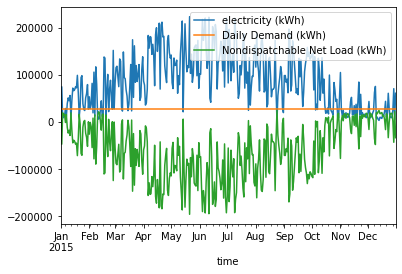

In [513]:
capacity_a = 30e6#starting point for capacity of solar farm

#turn into a class
PV_a = Produce_PV_Farm_Structure(df_epr1MW,capacity_a,power_intensity_epr)
PV_a_supp_demand = PV_a.df_day
PV_a_supp_demand['Daily Demand (kWh)']=Daily_Demand_End_List
PV_a_supp_demand['Nondispatchable Net Load (kWh)']=PV_a_supp_demand['Daily Demand (kWh)'] - PV_a_supp_demand['electricity (kWh)']
PV_a_supp_demand.plot()
h_stored4=np.zeros((366,1))
h_stored4[0]=60*daily_H2_demand

defficit=[]

for i in range(365):
    daily_h=0 #kwh
    daily_less=0
    x=0
    if PV_a_supp_demand['electricity (kWh)'][i]*0.56>daily_H2_demand:
        daily_excess=PV_a_supp_demand['electricity (kWh)'][i]-daily_H2_demand/0.56
        h_stored4[i+1]= h_stored4[i]+daily_excess*0.56*0.85

    if PV_a_supp_demand['electricity (kWh)'][i]*0.56<=daily_H2_demand:
        daily_less=daily_H2_demand-PV_a_supp_demand['electricity (kWh)'][i]*0.56
        h_stored4[i+1]= h_stored4[i]-daily_less
    h_stored4[i+1]=h_stored4[i+1]*0.97
    if  h_stored4[i]<=0:
        print('oh no')
        break

oh no


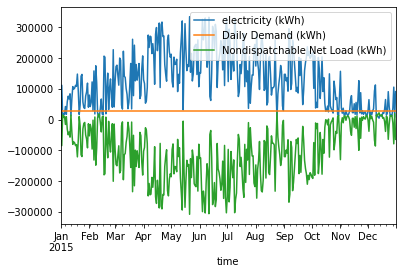

In [524]:
capacity_a = 45e6#starting point for capacity of solar farm

#turn into a class
PV_a = Produce_PV_Farm_Structure(df_epr1MW,capacity_a,power_intensity_epr)
PV_a_supp_demand = PV_a.df_day
PV_a_supp_demand['Daily Demand (kWh)']=Daily_Demand_End_List
PV_a_supp_demand['Nondispatchable Net Load (kWh)']=PV_a_supp_demand['Daily Demand (kWh)'] - PV_a_supp_demand['electricity (kWh)']
PV_a_supp_demand.plot()
h_stored5=np.zeros((366,1))
h_stored5[0]=120*daily_H2_demand

defficit=[]

for i in range(365):
    daily_h=0 #kwh
    daily_less=0
    x=0
    if PV_a_supp_demand['electricity (kWh)'][i]*0.56>daily_H2_demand:
        daily_excess=PV_a_supp_demand['electricity (kWh)'][i]-daily_H2_demand/0.56
        h_stored5[i+1]= h_stored5[i]+daily_excess*0.56*0.85

    if PV_a_supp_demand['electricity (kWh)'][i]*0.56<=daily_H2_demand:
        daily_less=daily_H2_demand-PV_a_supp_demand['electricity (kWh)'][i]*0.56
        h_stored5[i+1]= h_stored5[i]-daily_less
    h_stored5[i+1]=h_stored5[i+1]*0.97
    if  h_stored5[i]<=0:
        print('oh no')
        break

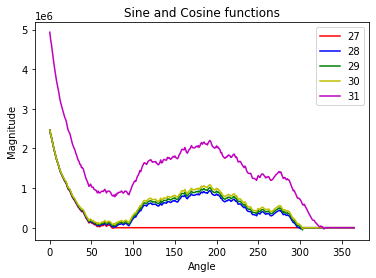

In [525]:
# Plotting both the curves simultaneously
Ndays = np.arange(0, 366, 1)
plt.plot(Ndays, h_stored, color='r', label='27')
plt.plot(Ndays, h_stored2, color='b', label='28')
plt.plot(Ndays, h_stored3, color='g', label='29')
plt.plot(Ndays, h_stored4, color='y', label='30')
plt.plot(Ndays, h_stored5, color='m', label='31')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Angle")
plt.ylabel("Magnitude")
plt.title("Sine and Cosine functions")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()

<AxesSubplot:xlabel='time'>

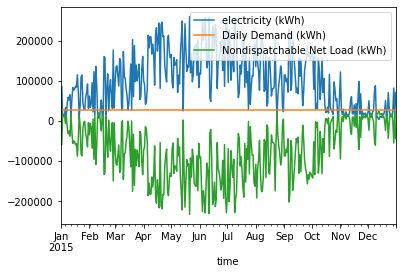

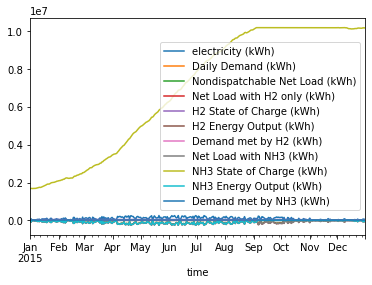

In [526]:
capacity_a =35e6#starting point for capacity of solar farm

#turn into a class
PV_a = Produce_PV_Farm_Structure(df_epr1MW,capacity_a,power_intensity_epr)
PV_a_supp_demand = PV_a.df_day
PV_a_supp_demand['Daily Demand (kWh)']=Daily_Demand_End_List
PV_a_supp_demand['Nondispatchable Net Load (kWh)']=PV_a_supp_demand['Daily Demand (kWh)'] - PV_a_supp_demand['electricity (kWh)']
PV_a_supp_demand.plot()



#add in storage of Hydrogen
eff_h2 = (0.56) #efficiency of electricity in -> energy into storage (assume same as energy in storage --> electricity out)

p_cap_h2 = max(abs(PV_a_supp_demand['Nondispatchable Net Load (kWh)']))/eff_h2 #power capacity of H2 in kWh/day
e_cap_h2 = daily_demand_end/eff_h2 #energy capacity should be a day's storage

#shorthand for the nondispatchable net load, put in list for ease
nd_nl = PV_a_supp_demand['Nondispatchable Net Load (kWh)'].values.tolist()

outputi_h2 = np.zeros((NDays,1)) # storage energy flow; assume all is in ammonia for the time being
soc_h2 = np.zeros((NDays,1))

#start with one day's storage
soc_h2[0] = PV_a_supp_demand['Daily Demand (kWh)'].resample('D').sum()[0]*1


#use battery model for hydrogen
for j in range(NDays):
    
    #charge in battery on 1st jan
    if j==0:
        socval = soc_h2[0]
    else:
        socval = soc_h2[j-1]
        
    #determine battery operation depending on nondispatchable net load
    if nd_nl[j] > 0:
        #power flow into battery is either the capacity, nondispatchable net load, or existing state of charge (if it is fully charged)
        outputi_h2[j]=min((p_cap_h2),nd_nl[j],eff_h2*socval) #amount of power flowing out of storage; * by eff due to losses
        soc_h2[j] = socval - (1/eff_h2)*outputi_h2[j]
        
    elif nd_nl[j] < 0:
        outputi_h2[j]=max(-p_cap_h2,nd_nl[j],-(1/eff_h2)*(e_cap_h2-socval)) #amount of power flowing into storage
        soc_h2[j] = socval - eff_h2*outputi_h2[j]
        
    elif nd_nl[j] == 0:
        soc_h2[j] = socval
        
#calculate the net load of the final system
net_load_h2 = nd_nl - outputi_h2
net_load_h2 = net_load_h2[0]
net_load_h2 = net_load_h2.tolist()

#append net load with hydrogen storage to dataframe and plot...
PV_a_supp_demand['Net Load with H2 only (kWh)'] = net_load_h2
PV_a_supp_demand['H2 State of Charge (kWh)'] = soc_h2
PV_a_supp_demand['H2 Energy Output (kWh)'] = outputi_h2
PV_a_supp_demand['Demand met by H2 (kWh)'] = PV_a_supp_demand['Nondispatchable Net Load (kWh)'] - PV_a_supp_demand['Net Load with H2 only (kWh)']



#add in ammonia storage
eff_nh3 = (0.32) #efficiency of electricity in -> energy into storage (assume same as energy in storage --> electricity out)

p_cap_nh3 = max(abs(PV_a_supp_demand['electricity (kWh)'])) #power capacity of H2 in kWh/day
e_cap_nh3 = PV_a_supp_demand['Daily Demand (kWh)'].resample('M').sum()[0]*12 #kWh, year's supply


outputi_nh3 = np.zeros((NDays,1)) # storage energy flow; assume all is in ammonia for the time being
soc_nh3 = np.zeros((NDays,1))

#start with two months storage
soc_nh3[0] = PV_a_supp_demand['Daily Demand (kWh)'].resample('M').sum()[0]*2


#use battery model for hydrogen
for j in range(NDays):
    
    #charge in battery on 1st jan
    if j==0:
        socval2 = soc_nh3[0]
    else:
        socval2 = soc_nh3[j-1]
        
    #determine battery operation depending on nondispatchable net load
    if net_load_h2[j] > 0:
        #power flow into battery is either the capacity, nondispatchable net load, or existing state of charge (if it is fully charged)
        outputi_nh3[j]=min((p_cap_nh3),net_load_h2[j],eff_nh3*socval2) #amount of power flowing out of storage; * by eff due to losses
        soc_nh3[j] = socval2 - (1/eff_nh3)*outputi_nh3[j]
        
    elif net_load_h2[j] < 0:
        outputi_nh3[j]=max(-p_cap_nh3,net_load_h2[j],-(1/eff_nh3)*(e_cap_nh3-socval2)) #amount of power flowing into storage
        soc_nh3[j] = socval2 - eff_nh3*outputi_nh3[j]
        
    elif net_load_h2[j] == 0:
        soc_nh3[j] = socval2
        
#calculate the net load of the final system
net_load_nh3 = net_load_h2 - outputi_nh3
net_load_nh3 = net_load_nh3[0]
net_load_nh3 = net_load_nh3.tolist()

#append net load with hydrogen storage to dataframe and plot...
PV_a_supp_demand['Net Load with NH3 (kWh)'] = net_load_nh3
PV_a_supp_demand['NH3 State of Charge (kWh)'] = soc_nh3
PV_a_supp_demand['NH3 Energy Output (kWh)'] = outputi_nh3
PV_a_supp_demand['Demand met by NH3 (kWh)'] = PV_a_supp_demand['Nondispatchable Net Load (kWh)'] - PV_a_supp_demand['Net Load with NH3 (kWh)']
PV_a_supp_demand.plot()


In [527]:
x=0
demand=15e6  #assume to be 10GWh
daily_H2_demand=demand/365
for i in range(365):
   
    if PV_a_supp_demand['electricity (kWh)'][i]/2<daily_H2_demand:
        x=x+1
        
x

163

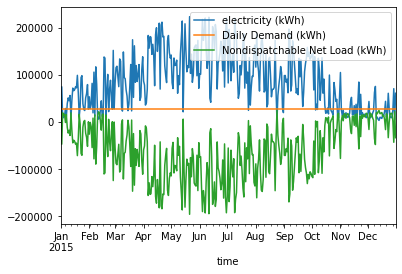

In [624]:
capacity_a =30e6#starting point for capacity of solar farm

#turn into a class
PV_a = Produce_PV_Farm_Structure(df_epr1MW,capacity_a,power_intensity_epr)
PV_a_supp_demand = PV_a.df_day
PV_a_supp_demand['Daily Demand (kWh)']=Daily_Demand_End_List
PV_a_supp_demand['Nondispatchable Net Load (kWh)']=PV_a_supp_demand['Daily Demand (kWh)'] - PV_a_supp_demand['electricity (kWh)']
PV_a_supp_demand.plot()
h_stored=np.zeros((366,1))
h_stored[0]=1*daily_H2_demand
nh3_produced=np.zeros((366,1))
nh3_produced[0]=0
defficit=[]


nh3=np.zeros((366,1))     #kwh
nh3[0]=30*daily_H2_demand

for i in range(365):
    daily_nh3=0 #kwh
    daily_h=0 #kwh
    daily_less=0
    x=0
    if PV_a_supp_demand['electricity (kWh)'][i]*0.56>daily_H2_demand:
        daily_excess=PV_a_supp_demand['electricity (kWh)'][i]-daily_H2_demand/0.56
        
        #not enough h2 for 14 days
        if 2*daily_H2_demand>h_stored[i]:
            daily_nh3=0   
            daily_h=daily_excess*0.56*0.9158
            x=h_stored[i]+daily_h
            nh3[i+1]=nh3[i]
            h_stored[i+1]=x
            
        if 2*daily_H2_demand<=h_stored[i]:
            excess_h_stored=(h_stored[i]-2*daily_H2_demand)/33.33   #kg
            daily_nh3=(daily_excess)*0.32  #kwh
            daily_nh3_mass=daily_nh3/6.25         #kg
            if excess_h_stored> daily_nh3_mass/17*2:
                    nh3[i+1]=nh3[i]+daily_nh3
                    daily_h=-daily_nh3_mass/17*2*33.33*0.9158
                    x=h_stored[i]+daily_h
                    h_stored[i+1]=x
                #not enough h2 in storage for production
            if excess_h_stored<= daily_nh3_mass/17*2:
                    nh3[i+1]=nh3[i]+excess_h_stored*33.33
                    x=h_stored[i]+daily_excess-excess_h_stored*33.33
                    h_stored[i+1]=x
        nh3_produced[i+1]=daily_nh3

    if PV_a_supp_demand['electricity (kWh)'][i]*0.56<=daily_H2_demand:
        daily_less=daily_H2_demand-PV_a_supp_demand['electricity (kWh)'][i]*0.56
        daily_nh3=0
        if nh3[i]>daily_less:
            nh3[i+1]=-daily_less+nh3[i]
            h_stored[i+1]=h_stored[i]
        if nh3[i]<=daily_less:
            daily_h=-daily_less+nh3[i]
            nh3[i+1]=0
            x=h_stored[i]+daily_h
            h_stored[i+1]=x
        nh3_produced[i+1]=daily_nh3
    h_stored[i+1]=h_stored[i+1]*0.98
    if  h_stored[i]<=0:
        print('oh no')
        break

 


In [615]:
60*daily_H2_demand

2465753.4246575343

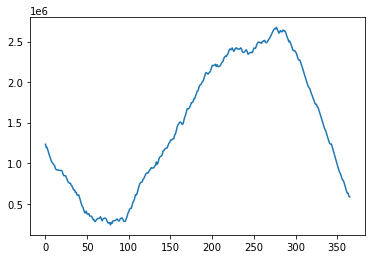

In [616]:
days=[i for i in range(366)]
plt.plot(days,nh3)

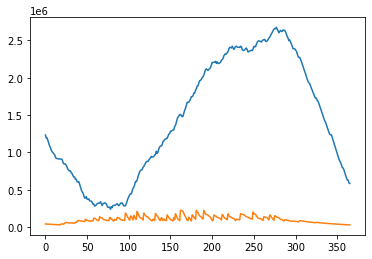

In [617]:
plt.plot(days,nh3)
plt.plot(days,h_stored)

In [618]:
x=0
for i in range(366):
    x=x+1
    if nh3[i]==0:
        break
x

366

In [623]:
max(h_stored)

array([226029.2601863])

In [458]:
daily_excess=PV_a_supp_demand['electricity (kWh)'][165]-daily_H2_demand/0.56
daily_excess
print(nh3[164])
print(nh3[165])
print(h_stored[164])
print(h_stored[165])
if 14*daily_H2_demand>h_stored[165]:
    daily_nh3=0   
    daily_h=daily_excess*0.56*0.85
    x=h_stored[i]+daily_h
    h_stored[i+1]=x
print(nh3[166])
print(h_stored[166])


[15441394.01719989]
[15449908.89125076]
[583432.32878187]
[573102.60158053]
[0.]
[628054.5741735]


In [621]:
#Cost modeling

In [626]:
sum(nh3_produced)

array([3590304.72255499])

NameError: name 'NH3_used_daily' is not defined